In [1]:
from os import path
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")


# Acquire Functions

- Used these to play around. Do not use these for final notebook. Use Kevin's!

In [2]:
def find_file(
    file_name='path/file.txt',
    cache=False,
    cache_age=None
    ):

    if cache==False:
        return None
    
    return path.exists(file_name)

In [3]:
def get_soup(
    url='https://github.com/search?o=desc&p=1&q=advent+of+code&s=stars&type=Repositories',
    headers={'User-Agent': 'Nothing suspicious'},
    file_name='soupfiles/gitsearch.txt',
    cache=False,
    cache_age=None,
    soup_slurper='*'
):
    # if we already have the data, read it locally
    file_found = find_file(file_name=file_name, cache=cache, cache_age=cache_age)
    if file_found:
        with open(file_name) as f:
            return BeautifulSoup(f.read())

    # otherwise go fetch the data
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text)
    slurps = soup.select(soup_slurper)

    # save it for next time
    with open(file_name, 'w') as f:
        f.write(str(slurps[0]))
        if len(slurps)>1:
            for slurp in slurps[1:]:
                f.write('\n' + str(slurp))
        
    with open(file_name) as f:    
        soup = BeautifulSoup(f.read())
#     pd.to_csv(slurps, header=None, index=False)

    return soup

In [4]:
def all_repositories():
    page = str(range(1,21))
    repo_list = []
    for p in page:
        repo_list.extend(get_links_from_page('https://github.com/search?o=desc&p='+p+'&q=advent+of+code&s=stars&type=Repositories'))
        return repo_list

In [5]:
def get_links_from_page(url):
    soup = get_soup(
    url=url,
    cache=True,
    soup_slurper='.repo-list-item a',
    file_name='soupfiles/gitsearch.txt'
)

# Prepare

## Functions

In [6]:
def normalize(string):
    # lower case the string
    string = string.lower()

    # replace new lines with an empty space
    string = re.sub(r'\n',' ',string)
    
    # normalize unicode characters
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # replace . with space
    string = re.sub(r'\.',' ',string)
    
    # replace / with space
    string = re.sub(r'/',' ',string)
    
    # replace c++ th c plus plus
    string = re.sub(r'c\+\+','cplusplus',string)

    # replace c+ with c plus
    string = re.sub(r'c\+','cplus ',string)

    # replace c# with c sharp
    string = re.sub(r'c#','csharp ',string)

    # replace f# with f sharp
    string = re.sub(r'f#','fsharp ',string)
    
    # replaces certain special characters with a space
    string = re.sub(r'[\[\](){}]',' ', string)
    
    # replace extra spaces with only one space
    string = re.sub(r'\s+',' ',string)

    # remove special characters with regex
    string = re.sub(r'[^a-z\s]','', string)
    
    return string

In [7]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

In [8]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

In [9]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

In [10]:
def remove_stopwords(tokenized_string, extra_words=['advent', 'of','code', 'aoc', 'day', 'solution', 'httpsgithub','githubhttpsimg','hpphttpsgithub','httpsadventofcode', 'adventofcode','commstksgadventofcodeblobmasterreflections', 'httpadventofcode','com', 'github', 'http', 'https','adventofcodehttps','master','blob','username', 'reponame','svg','src'], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Read in json file containing repos and content

In [11]:
# read in content as json and save as dataframe
df = pd.read_json('datafiles/outdata.json')

In [12]:
type(df)

pandas.core.frame.DataFrame

In [13]:
# preview data
df.shape

(302, 6)

In [14]:
df.head(20)

,language,language_all,repo_full,author,repo,readme
0,Python,{'Python': 41534},0x8b/advent-of-code-2019,0x8b,advent-of-code-2019,# username's [advent of code 2019](https://adv...
1,Haskell,"{'Haskell': 42115, 'Python': 503}",1Computer1/advent,1Computer1,advent,# reponame of code solutions\n\ni'm probably n...
10,TypeScript,"{'TypeScript': 178903, 'Rust': 68139, 'Smarty'...",AlexAegis/advent-of-code,AlexAegis,advent-of-code,# [advent of code](https://adventofcode.com/)\...
100,Python,"{'Python': 64874, 'Julia': 27162}",ferrolho/advent-of-code,ferrolho,advent-of-code,# advent of code\n\n:santa: :christmas_tree: :...
101,Swift,{'Swift': 69603},fguchelaar/AdventOfCode2019,fguchelaar,AdventOfCode2019,# advent of code 2019\n\nmy solutions for the ...
102,JavaScript,{'JavaScript': 80195},fhinkel/AdventOfCode2018,fhinkel,AdventOfCode2018,# advent of code 2018 with node.js 10\n\n[adve...
103,Elixir,{'Elixir': 13750},Firebain/adventofcode,Firebain,adventofcode,# adventtocode\n\n**todo: add description**\n\...
104,Scala,{'Scala': 32237},FlorianCassayre/AdventOfCode-2017,FlorianCassayre,AdventOfCode-2017,_my solutions to the 2017 edition of [advent o...
105,Scala,{'Scala': 42155},FlorianCassayre/AdventOfCode-2018,FlorianCassayre,AdventOfCode-2018,_my solutions to the 2018 edition of [advent o...
106,Scala,{'Scala': 19179},FlorianCassayre/AdventOfCode-2019,FlorianCassayre,AdventOfCode-2019,_my solutions to the 2019 edition of [advent o...


### Create new columns which show readme content normalized, stemmed, and lemmatized

In [15]:
df = df.assign(normalized = df.readme.apply(normalize))
df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))

In [16]:
# preview results to decide which technique to use when reducing form of words (lemmatize vs stemming)
df

,language,language_all,repo_full,author,repo,readme,normalized,stemmed,lemmatized
0,Python,{'Python': 41534},0x8b/advent-of-code-2019,0x8b,advent-of-code-2019,# username's [advent of code 2019](https://adv...,usernames advent of code https adventofcode ...,usernam advent of code http adventofcod com so...,usernames advent of code http adventofcode com...
1,Haskell,"{'Haskell': 42115, 'Python': 503}",1Computer1/advent,1Computer1,advent,# reponame of code solutions\n\ni'm probably n...,reponame of code solutions im probably not go...,reponam of code solut im probabl not gonna do ...,reponame of code solution im probably not gonn...
10,TypeScript,"{'TypeScript': 178903, 'Rust': 68139, 'Smarty'...",AlexAegis/advent-of-code,AlexAegis,advent-of-code,# [advent of code](https://adventofcode.com/)\...,advent of code https adventofcode com build ...,advent of code http adventofcod com build stat...,advent of code http adventofcode com build sta...
100,Python,"{'Python': 64874, 'Julia': 27162}",ferrolho/advent-of-code,ferrolho,advent-of-code,# advent of code\n\n:santa: :christmas_tree: :...,advent of code santa christmastree gift my so...,advent of code santa christmastre gift my solu...,advent of code santa christmastree gift my sol...
101,Swift,{'Swift': 69603},fguchelaar/AdventOfCode2019,fguchelaar,AdventOfCode2019,# advent of code 2019\n\nmy solutions for the ...,advent of code my solutions for the fifth in...,advent of code my solut for the fifth instal o...,advent of code my solution for the fifth insta...
102,JavaScript,{'JavaScript': 80195},fhinkel/AdventOfCode2018,fhinkel,AdventOfCode2018,# advent of code 2018 with node.js 10\n\n[adve...,advent of code with node js advent of code ...,advent of code with node js advent of code htt...,advent of code with node j advent of code http...
103,Elixir,{'Elixir': 13750},Firebain/adventofcode,Firebain,adventofcode,# adventtocode\n\n**todo: add description**\n\...,adventtocode todo add description installati...,adventtocod todo add descript instal if avail ...,adventtocode todo add description installation...
104,Scala,{'Scala': 32237},FlorianCassayre/AdventOfCode-2017,FlorianCassayre,AdventOfCode-2017,_my solutions to the 2017 edition of [advent o...,my solutions to the edition of advent of code...,my solut to the edit of advent of code http ad...,my solution to the edition of advent of code h...
105,Scala,{'Scala': 42155},FlorianCassayre/AdventOfCode-2018,FlorianCassayre,AdventOfCode-2018,_my solutions to the 2018 edition of [advent o...,my solutions to the edition of advent of code...,my solut to the edit of advent of code http ad...,my solution to the edition of advent of code h...
106,Scala,{'Scala': 19179},FlorianCassayre/AdventOfCode-2019,FlorianCassayre,AdventOfCode-2019,_my solutions to the 2019 edition of [advent o...,my solutions to the edition of advent of code...,my solut to the edit of advent of code http ad...,my solution to the edition of advent of code h...


In [17]:
# People are not very creative with their repo names. 
df.repo.value_counts()

advent-of-code                  35
advent-of-code-2019             23
adventofcode                    16
AdventOfCode                    16
advent-of-code-2018             11
AdventOfCode2019                11
AdventOfCode2018                 8
aoc-2019                         7
adventofcode2019                 6
aoc2019                          5
aoc2017                          4
advent2019                       4
AdventOfCode2015                 4
AdventOfCode2017                 4
advent_of_code_2019              3
adventOfCode                     3
advent-2019                      3
aoc19                            3
Advent-of-Code-2019              3
advent-of-code-2017              3
advent-of-code-2015              3
aoc                              3
AdventOfCode-2017                2
advent2017                       2
Advent-of-Code                   2
AdventOfCode-2019                2
advent_of_code                   2
advent_of_code_2018              2
advent-of-code-2016 

In [18]:
# choose lemmatize and proceed forward with tokenization and stop words
# create new column called prepped which takes the lemmatized column and passes it through the tokenize function and remove_stopwords function
df = df.assign(prepped = df.lemmatized.apply(tokenize).apply(remove_stopwords))

In [19]:
df.head(5)

,language,language_all,repo_full,author,repo,readme,normalized,stemmed,lemmatized,prepped
0,Python,{'Python': 41534},0x8b/advent-of-code-2019,0x8b,advent-of-code-2019,# username's [advent of code 2019](https://adv...,usernames advent of code https adventofcode ...,usernam advent of code http adventofcod com so...,usernames advent of code http adventofcode com...,usernames daynamesolution tyranny rocket equat...
1,Haskell,"{'Haskell': 42115, 'Python': 503}",1Computer1/advent,1Computer1,advent,# reponame of code solutions\n\ni'm probably n...,reponame of code solutions im probably not go...,reponam of code solut im probabl not gonna do ...,reponame of code solution im probably not gonn...,im probably gonna problem im gonna pretend lik...
10,TypeScript,"{'TypeScript': 178903, 'Rust': 68139, 'Smarty'...",AlexAegis/advent-of-code,AlexAegis,advent-of-code,# [advent of code](https://adventofcode.com/)\...,advent of code https adventofcode com build ...,advent of code http adventofcod com build stat...,advent of code http adventofcode com build sta...,build status travisci svgbranchmaster travisci...
100,Python,"{'Python': 64874, 'Julia': 27162}",ferrolho/advent-of-code,ferrolho,advent-of-code,# advent of code\n\n:santa: :christmas_tree: :...,advent of code santa christmastree gift my so...,advent of code santa christmastre gift my solu...,advent of code santa christmastree gift my sol...,santa christmastree gift problem might write s...
101,Swift,{'Swift': 69603},fguchelaar/AdventOfCode2019,fguchelaar,AdventOfCode2019,# advent of code 2019\n\nmy solutions for the ...,advent of code my solutions for the fifth in...,advent of code my solut for the fifth instal o...,advent of code my solution for the fifth insta...,fifth installment creating package ive prepare...


In [20]:
# 26 blank readme's as a result of removing stop words.need to drop them
df.prepped.value_counts().head()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              26
puzzle                                                                                                                                                                                                                                                                                                                                                 

In [21]:
mask = df.prepped != ''
df = df[mask]
df.prepped.value_counts()

python                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# Explore

In [22]:
# isolate language and prepped columns
df = df.drop(columns={'author','language_all','readme','repo','normalized', 'stemmed', 'lemmatized','repo_full'})

In [23]:
df.head()

,language,prepped
0,Python,usernames daynamesolution tyranny rocket equat...
1,Haskell,im probably gonna problem im gonna pretend lik...
10,TypeScript,build status travisci svgbranchmaster travisci...
100,Python,santa christmastree gift problem might write s...
101,Swift,fifth installment creating package ive prepare...


### How many repos of each language exist?

In [24]:
df.language.value_counts(normalize=False)

Python              39
JavaScript          35
Haskell             25
Rust                19
Clojure             15
Go                  14
Java                12
Kotlin              12
C#                  10
Ruby                10
Elixir               9
Scala                8
C++                  8
R                    7
OCaml                5
TypeScript           4
Jupyter Notebook     3
PHP                  3
C                    3
Pony                 2
Julia                2
Perl                 2
Elm                  2
Swift                2
Crystal              2
HTML                 2
Scheme               2
F#                   2
Haxe                 1
TSQL                 1
Mathematica          1
Smalltalk            1
Eiffel               1
PowerShell           1
Erlang               1
Coq                  1
D                    1
APL                  1
Reason               1
Nim                  1
Racket               1
Ada                  1
Dart                 1
PureScript 

### What percentage is this?

In [25]:
df.language.value_counts(normalize=True)

Python              0.141304
JavaScript          0.126812
Haskell             0.090580
Rust                0.068841
Clojure             0.054348
Go                  0.050725
Java                0.043478
Kotlin              0.043478
C#                  0.036232
Ruby                0.036232
Elixir              0.032609
Scala               0.028986
C++                 0.028986
R                   0.025362
OCaml               0.018116
TypeScript          0.014493
Jupyter Notebook    0.010870
PHP                 0.010870
C                   0.010870
Pony                0.007246
Julia               0.007246
Perl                0.007246
Elm                 0.007246
Swift               0.007246
Crystal             0.007246
HTML                0.007246
Scheme              0.007246
F#                  0.007246
Haxe                0.003623
TSQL                0.003623
Mathematica         0.003623
Smalltalk           0.003623
Eiffel              0.003623
PowerShell          0.003623
Erlang        

### What are the most common words in READMEs?

In [26]:
# get all text as a string
all_text = " ".join(df.prepped)
# convert to a list of words
all_words = all_text.split()

In [27]:
raw_count = pd.Series(all_words).value_counts()
raw_count.head(30)

main              380
run               375
scala             327
input             315
part              292
hpp               288
problem           276
py                246
year              231
puzzle            227
test              210
io                192
r                 186
cpp               180
challenge         172
nim               170
reflection        164
post              161
heavycheckmark    157
include           154
file              154
tree              146
python            139
md                135
ginsberg          130
using             123
www               120
f                 120
rb                118
go                117
dtype: int64

Text(0.5, 1.0, '25 most common words')

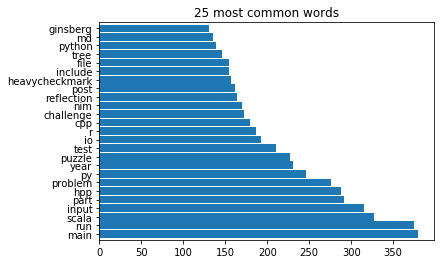

In [28]:
raw_count.sort_values(ascending=False)[0:25].plot.barh(width=.9)
plt.title('25 most common words')

### How does this look for popular languages?

#### Python

In [29]:
python_text = " ".join(df[df.language == "Python"].prepped)
python_words = python_text.split()

In [30]:
python_count = pd.Series(python_words).value_counts()
python_count.head(15)

py                161
python             56
part               47
run                38
hand               35
model              33
puzzle             33
image              30
tensorflow         29
input              29
training           28
p                  28
heavycheckmark     26
repo               23
searching          23
dtype: int64

Text(0.5, 1.0, 'Python 10 most common words')

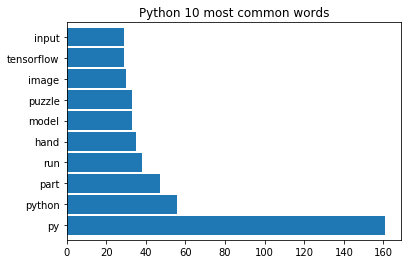

In [31]:
python_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Python 10 most common words')

#### Haskell

In [32]:
haskell_text = " ".join(df[df.language == "Haskell"].prepped)
haskell_words = haskell_text.split()

In [33]:
haskell_count = pd.Series(haskell_words).value_counts()
haskell_count.head(15)

reflection         164
db                  96
dr                  91
challenge           89
h                   66
dh                  64
dg                  64
benchmark           52
dc                  50
mdday               49
mddaybenchmarks     48
haskell             47
b                   44
test                43
run                 38
dtype: int64

Text(0.5, 1.0, 'Haskell 10 most common words')

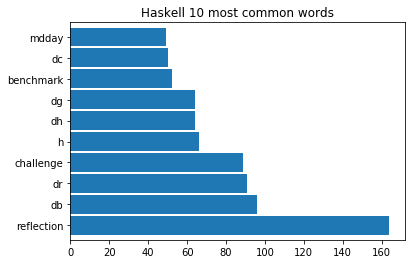

In [34]:
haskell_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Haskell 10 most common words')

#### JavaScript

In [35]:
javascript_text = " ".join(df[df.language == "JavaScript"].prepped)
javascript_words = javascript_text.split()

In [36]:
javascript_count = pd.Series(javascript_words).value_counts()
javascript_count.head(15)

run                64
j                  59
star               49
puzzle             48
part               40
npm                40
index              38
test               36
year               34
input              33
simulation         27
net                26
post               26
adventofcodeday    25
node               25
dtype: int64

Text(0.5, 1.0, 'JavaScript 10 most common words')

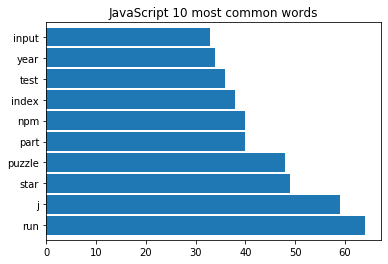

In [37]:
javascript_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('JavaScript 10 most common words')

#### Java

In [38]:
java_text = " ".join(df[df.language == "Java"].prepped)
java_words = java_text.split()

In [39]:
java_count = pd.Series(java_words).value_counts()
java_count.head(15)

java         45
problem      33
tree         26
statement    25
run          23
input        21
main         16
language     14
sbaars       11
io           11
shield       11
img          11
part         10
badge         9
script        8
dtype: int64

Text(0.5, 1.0, 'Java 10 most common words')

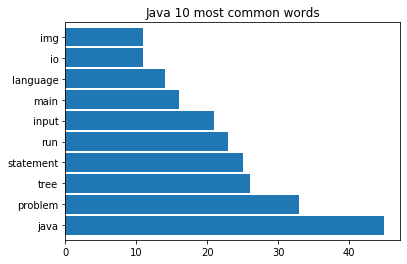

In [40]:
java_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Java 10 most common words')

### Does the length of the README vary by programming language?

# Modeling

In [41]:
tf_df = pd.DataFrame({'raw_count': raw_count})
tf_df = tf_df.assign(term_frequency = lambda df: df.raw_count / df.raw_count.sum())
tf_df.raw_count.max()
tf_df.head()

,raw_count,term_frequency
main,380,0.012543
run,375,0.012378
scala,327,0.010794
input,315,0.010397
part,292,0.009638


In [42]:
def idf(word):
    n_occurrences = sum([1 for doc in df.prepped if word in doc])
    n_docs = len(df.prepped)
    idf = np.log(n_docs/n_occurrences)
    return idf

In [43]:
idf('python')

1.9828147059907644

In [44]:
idf('shield')

2.529358412358834

In [45]:
idf('model')

4.5217885770490405

In [46]:
unique_words = pd.Series(' '.join(df.prepped).split()).unique()
len(unique_words)

4447

In [47]:
word_df = pd.DataFrame(dict(word = unique_words))
word_df = word_df.assign(idf = lambda df: df.word.apply(idf))
word_df = word_df.set_index('word').sort_values(by='idf', ascending = False)
word_df.head(100)

,idf
word,
coqsimpleio,5.620401
feeddict,5.620401
imagenpexpanded,5.620401
drawboxonimage,5.620401
detectmultithreaded,5.620401
threaded,5.620401
camera,5.620401
videe,5.620401
detectsinglethreaded,5.620401


In [48]:
df.language.value_counts()

Python              39
JavaScript          35
Haskell             25
Rust                19
Clojure             15
Go                  14
Java                12
Kotlin              12
C#                  10
Ruby                10
Elixir               9
Scala                8
C++                  8
R                    7
OCaml                5
TypeScript           4
Jupyter Notebook     3
PHP                  3
C                    3
Pony                 2
Julia                2
Perl                 2
Elm                  2
Swift                2
Crystal              2
HTML                 2
Scheme               2
F#                   2
Haxe                 1
TSQL                 1
Mathematica          1
Smalltalk            1
Eiffel               1
PowerShell           1
Erlang               1
Coq                  1
D                    1
APL                  1
Reason               1
Nim                  1
Racket               1
Ada                  1
Dart                 1
PureScript 

Make Other Label for non top 5 languages

In [49]:
df['language'] = df['language'].replace({'C++':'Other', 'Scala':'Other', 'OCaml':'Other','C':'Other', 'Elm':'Other', 'Pony':'Other', 'HTML':'Other', 'Perl':'Other','APL':'Other', 'Haxe':'Other', 'Racket':'Other', 'PureScript':'Other', 'Coq':'Other','F#':'Other', 'PHP':'Other', 'TSQL':'Other', 'Crystal':'Other', 'Nim':'Other', 'Shell':'Other', 'Eiffel':'Other', 'Mathematica':'Other', 'Swift':'Other', 'Reason':'Other', 'TypeScript':'Other', 'Jupyter Notebook':'Python', 'Scheme':'Other', 'Powershell':'Other', 'Julia':'Other', 'PowerShell':'Other', 'Ada':'Other', 'Erlang':'Other', 'Smalltalk':'Other', 'D':'Other', 'Dart':'Other', 'R':'Other'})

In [50]:
df.language.value_counts()

Other         73
Python        42
JavaScript    35
Haskell       25
Rust          19
Clojure       15
Go            14
Java          12
Kotlin        12
C#            10
Ruby          10
Elixir         9
Name: language, dtype: int64

In [51]:
#df = df[df['language'].isin(['Python', 'Haskell','JavaScript'])]

In [52]:
df.prepped.value_counts()

python                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Split

In [53]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.prepped)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

## Model 1: Logistic Regression

In [54]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

### Train Evaluation

In [55]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 66.36%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0        5       0   0        0     0           0       0      0   
Go           0        0       0   3        0     0           0       0      0   
Haskell      0        0       0   0       11     0           0       0      0   
Java         0        0       0   0        0     2           0       0      0   
JavaScript   0        1       0   0        0     1          24       0      1   
Kotlin       0        0       0   0        0     0           0       3      0   
Other        8        6       7   8        9     7           4       7     57   
Python       0        0       0   0        0     0           0       0      0   
Ruby         0        0       0   0        0     0           0       0      0   
Rust         0        0       0   0        0     0           0       0 

## Model 2: Decision Tree

In [56]:
# Create
tree = DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=123)
# Fit
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [57]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = tree.predict(X_train)
test['predicted'] = tree.predict(X_test)

### Train Evaluation

In [58]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 71.82%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0       10       0   0        0     0           0       0      0   
Elixir       0        0       7   0        0     0           0       0      0   
Go           0        0       0   8        0     0           3       0      2   
Haskell      0        0       0   0       12     0           0       0      0   
Java         0        0       0   0        0     4           0       0      0   
JavaScript   0        0       0   0        0     0          12       0      0   
Kotlin       0        0       0   0        0     0           0       7      0   
Other        8        2       0   3        8     6          13       3     56   
Python       0        0       0   0        0     0           0       0      0   
Ruby         0        0       0   0        0     0           0       0 

## Model 3: Random Forest

In [59]:
# Create
rf = RandomForestClassifier(min_samples_leaf=3, max_depth=9, random_state=123)
# Fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [60]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

### Train Evaluation

In [61]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 58.64%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
C#           2        0       0   0        0     0           0       0      0   
Clojure      0        2       0   0        0     0           0       0      0   
Elixir       0        0       7   0        0     1           0       0      0   
Go           0        0       0   1        0     0           0       0      0   
Haskell      0        0       0   0       10     0           0       0      0   
Java         0        0       0   0        0     5           1       0      0   
JavaScript   0        0       0   0        0     0          15       1      0   
Kotlin       0        0       0   0        0     0           0       5      0   
Other        6        8       0  10       10     4          12       4     58   
Python       0        2       0   0        0     0           0       0 

## Model 4: K-Nearest Neighbors

In [62]:
# Create
knn=KNeighborsClassifier(n_neighbors=8,weights='uniform')
# Fit
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [63]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = knn.predict(X_train)
test['predicted'] = knn.predict(X_test)

### Train Evaluation

In [64]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 67.73%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
C#           3        0       0   0        0     0           0       0      3   
Clojure      0       11       0   0        0     0           0       0      1   
Elixir       0        0       6   0        0     0           0       0      0   
Go           0        0       0   7        0     1           1       3      2   
Haskell      1        0       0   0       15     0           1       0      1   
Java         0        0       0   0        1     4           0       0      4   
JavaScript   1        0       0   2        2     4          24       3      7   
Kotlin       0        0       0   0        0     0           1       3      1   
Other        1        0       0   2        0     1           1       1     37   
Python       2        1       1   0        0     0           0       0 

## Test Evaluation

Our best perfoming model is the decision tree. Let's run our model on the test data to see how it does. 


In [65]:
# Create
tree = DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=123)
# Fit
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [66]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = tree.predict(X_train)
test['predicted'] = tree.predict(X_test)

In [67]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 50.00%
---
Confusion Matrix
actual      C#  Clojure  Elixir  Go  Haskell  Java  JavaScript  Kotlin  Other  \
predicted                                                                       
Clojure      0        2       0   0        0     0           0       0      0   
Elixir       0        0       2   0        0     0           0       0      0   
Go           0        0       0   1        0     0           1       0      0   
Haskell      0        0       0   0        2     0           0       0      0   
JavaScript   0        0       0   0        0     0           2       0      1   
Kotlin       0        0       0   0        0     0           0       1      0   
Other        1        1       0   2        3     1           3       1     13   
Python       0        0       0   0        0     1           1       0      1   
Ruby         1        0       0   0        0     0           0       0      0   
Rust         0        0       0   0        0     0           0       0 